In [41]:
import ta
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import FinanceDataReader as fdr
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from yahooquery import Ticker
from fredapi import Fred
from datetime import datetime
from bs4 import BeautifulSoup
from pandas_datareader import data as pdr
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import datetime as dt
import tensorflow as tf
import matplotlib.dates as mdates
import xgboost as xgb
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, learning_curve
from keras.regularizers import L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

today = datetime.today().strftime('%Y-%m-%d')

In [42]:
ticker = 'aapl' 
start_date = '2013-09-28'
end_date = '2024-09-18'

# 1.1. Technical data

In [43]:
stock_df = yf.download(ticker, start = start_date, end = end_date)

## 1.1. Simple Moving Average (SMA)
stock_df['MA5'] = stock_df['Adj Close'].rolling(window=5).mean()        # 5일 SMA
stock_df['MA20'] = stock_df['Adj Close'].rolling(window=20).mean()      # 20일 SMA
stock_df['MA60'] = stock_df['Adj Close'].rolling(window=60).mean()      # 60일 SMA
stock_df['MA120'] = stock_df['Adj Close'].rolling(window=120).mean()    # 120일 SMA

## 1.2. Exponential Moving Average (EMA)
stock_df['EMA5'] = stock_df['Adj Close'].ewm(span=5, adjust=False).mean()       # 5일 EMA
stock_df['EMA20'] = stock_df['Adj Close'].ewm(span=20, adjust=False).mean()     # 20일 EMA
stock_df['EMA60'] = stock_df['Adj Close'].ewm(span=60, adjust=False).mean()     # 60일 EMA
stock_df['EMA120'] = stock_df['Adj Close'].ewm(span=120, adjust=False).mean()   # 120일 EMA

## 1.3. Double Bollinger Bands indicator

# Central Line (20-day moving average)
stock_df['BOL_AVG'] = ta.volatility.bollinger_mavg(stock_df['Adj Close'])

# Double Bollinger Bands
stock_df['BOL_H1'] = stock_df['BOL_AVG'] + 2 * stock_df['Adj Close'].rolling(window=20).std()
stock_df['BOL_L1'] = stock_df['BOL_AVG'] - 2 * stock_df['Adj Close'].rolling(window=20).std()
stock_df['BOL_H2'] = stock_df['BOL_AVG'] + stock_df['Adj Close'].rolling(window=20).std()
stock_df['BOL_L2'] = stock_df['BOL_AVG'] - stock_df['Adj Close'].rolling(window=20).std()

## 1.4. Relative Strength Index (RSI)
stock_df['RSI'] = ta.momentum.rsi(stock_df['Adj Close'])

## 1.5. Moving Average Convergence Divergence (MACD)
stock_df['MACD'] = ta.trend.macd(stock_df['Adj Close'])
stock_df['MACD_SIGNAL']= ta.trend.macd_signal(stock_df['Adj Close'])

## 1.6. On-Balance Volume (OBV)
stock_df['OBV'] = ta.volume.on_balance_volume(stock_df['Adj Close'], stock_df['Volume'])

stock_df.tail(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,MA5,MA20,MA60,MA120,...,EMA120,BOL_AVG,BOL_H1,BOL_L1,BOL_H2,BOL_L2,RSI,MACD,MACD_SIGNAL,OBV
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-04,221.660004,221.779999,217.479996,220.850006,220.850006,43840200,225.780002,223.210040,219.889448,198.999688,...,206.308786,223.210040,234.116572,212.303509,228.663306,217.756775,46.413526,1.804589,2.204546,12061276300
2024-09-05,221.630005,225.479996,221.520004,222.380005,222.380005,36615400,224.958002,223.850169,220.380836,199.414805,...,206.574426,223.850169,232.695857,215.004481,228.273013,219.427325,49.111619,1.472097,2.058056,12097891700
2024-09-06,223.949997,225.240005,219.770004,220.820007,220.820007,48423000,223.164005,224.238000,220.612661,199.820081,...,206.809890,224.238000,231.657581,216.818420,227.947791,220.528210,46.538658,1.070378,1.860521,12049468700
2024-09-09,220.820007,221.270004,216.710007,220.910004,220.910004,67180000,221.546005,224.484000,220.747434,200.216963,...,207.042950,224.484000,231.026560,217.941441,227.755280,221.212721,46.712104,0.750622,1.638541,12116648700
2024-09-10,218.919998,221.479996,216.729996,220.110001,220.110001,51591000,221.014005,224.613000,220.849395,200.587562,...,207.258934,224.613000,230.661316,218.564685,227.637158,221.588843,45.305016,0.427729,1.396378,12065057700
2024-09-11,221.460007,223.089996,217.889999,222.660004,222.660004,44587100,221.376004,224.682500,221.022990,200.957881,...,207.513497,224.682500,230.599595,218.765406,227.641048,221.723953,50.430554,0.373294,1.191762,12109644800
2024-09-12,222.500000,223.550003,219.820007,222.770004,222.770004,37498200,221.454004,224.735001,221.128831,201.389797,...,207.765671,224.735001,230.559326,218.910675,227.647163,221.822838,50.645416,0.335167,1.020443,12147143000
2024-09-13,223.580002,224.039993,221.910004,222.500000,222.500000,36766600,221.790002,224.624001,221.269794,201.811900,...,208.009214,224.624001,230.533524,218.714477,227.578762,221.669239,50.071699,0.279937,0.872342,12110376400
2024-09-16,216.539993,217.220001,213.919998,216.320007,216.320007,59357400,220.872003,224.137501,221.384501,202.194389,...,208.146582,224.137501,231.066781,217.208220,227.602141,220.672860,39.142125,-0.259515,0.645970,12051019000


# 1.2. Fundamental _ Econ

DGS, T10Y2Y, VIX = 일별로

Unemployment_Rate, CPI, FEDFUNDS = 월별로 (말에 발표)

GDP = 3달마다




In [44]:
adj_close_df = stock_df[['Adj Close']]

## 2.1. U.S. Treasury bond yields 
fred = Fred(api_key = '4c55d0ee6170369793707da4cba1b7be')
dgs2 = fred.get_series('DGS2', observation_start=start_date, observation_end=end_date)      # 2년 DGS
dgs5 = fred.get_series('DGS5', observation_start=start_date, observation_end=end_date)      # 5년 DGS
dgs10 = fred.get_series('DGS10', observation_start=start_date, observation_end=end_date)    # 10년 DGS

DGS = pd.concat([dgs2, dgs5,dgs10], axis=1)
DGS.columns = ['2-year', '5-year', '10-year']
DGS.index.name = 'Date'
DGS = DGS.reset_index()

## 2.2. U.S. long-short interest rate spread (10-year & 2-year)
T10Y2Y = fdr.DataReader('FRED:T10Y2Y', start_date, end_date)
T10Y2Y.index.name = 'Date'

## 2.3. Volatility Index (VIX)
VIX = fdr.DataReader('FRED:VIXCLS', start_date, end_date)
VIX.index.name = 'Date'
VIX = VIX.reset_index()

merged_df = pd.DataFrame()
merged_df = pd.concat([merged_df, DGS], ignore_index=True)
merged_df = merged_df.merge(T10Y2Y, on='Date')
econ_df = merged_df.merge(VIX, on='Date')

econ_df['Date'] = pd.to_datetime(econ_df['Date'])
econ_df.set_index('Date', inplace=True)

econ_df.tail(10)

,2-year,5-year,10-year,T10Y2Y,VIXCLS
Date,,,,,
2024-09-05,3.75,3.54,3.73,-0.02,19.90
2024-09-06,3.66,3.50,3.72,0.06,22.38
2024-09-09,3.68,3.49,3.70,0.02,19.45
2024-09-10,3.59,3.43,3.65,0.06,19.08
2024-09-11,3.62,3.45,3.65,0.03,17.69
2024-09-12,3.64,3.47,3.68,0.04,17.07
2024-09-13,3.57,3.43,3.66,0.09,16.56
2024-09-16,3.56,3.41,3.63,0.07,17.14
2024-09-17,3.59,3.44,3.65,0.06,17.61


In [26]:
# adj_close_df = stock_df[['Adj Close']]

# ## 2.1. U.S. Treasury bond yields 
# fred = Fred(api_key = '4c55d0ee6170369793707da4cba1b7be')
# dgs2 = fred.get_series('DGS2', observation_start=start_date, observation_end=end_date)      # 2년 DGS
# dgs5 = fred.get_series('DGS5', observation_start=start_date, observation_end=end_date)      # 5년 DGS
# dgs10 = fred.get_series('DGS10', observation_start=start_date, observation_end=end_date)    # 10년 DGS

# DGS = pd.concat([dgs2, dgs5,dgs10], axis=1)
# DGS.columns = ['2-year', '5-year', '10-year']
# DGS.index.name = 'Date'
# DGS = DGS.reset_index()

# ## 2.2. U.S. long-short interest rate spread (10-year & 2-year)
# T10Y2Y = fdr.DataReader('FRED:T10Y2Y', start_date, end_date)
# T10Y2Y.index.name = 'Date'

# ## 2.3. Volatility Index (VIX)
# VIX = fdr.DataReader('FRED:VIXCLS', start_date, end_date)
# VIX.index.name = 'Date'
# VIX = VIX.reset_index()

# ## 2.4. Unemployment Rate
# Unemployment_Rate = fdr.DataReader('FRED:UNRATE', start_date, end_date)
# Unemployment_Rate.index.name = 'Date'
# Unemployment_Rate = Unemployment_Rate.reset_index()

# ## 2.5. Consumer Price Index (CPI)
# CPI = fdr.DataReader('FRED:CPIAUCSL', start_date, end_date)
# CPI.index.name = 'Date'
# CPI = CPI.reset_index()

# ## 2.6. Federal funds rate
# FEDFUNDS = fdr.DataReader('FRED:FEDFUNDS', start_date, end_date)
# FEDFUNDS.index.name = 'Date'
# FEDFUNDS = FEDFUNDS.reset_index()

# ## 2.7. Gross Domestic Product (GDP)
# GDP = pd.DataFrame(fred.get_series('GDP',observation_start=start_date, observation_end = end_date),columns=['GDP'])
# GDP.index.name = 'Date'
# GDP = GDP.reset_index()


# ###############
# DGS_og = DGS.copy()
# T10Y2Y_og = T10Y2Y.copy()
# Unemployment_Rate_og = Unemployment_Rate.copy()
# CPI_og = CPI.copy()
# VIX_og = VIX.copy()
# FEDFUNDS_og = FEDFUNDS.copy()
# GDP_og = GDP.copy()

# og_df = pd.DataFrame()
# og_df = pd.concat([og_df, DGS_og], ignore_index=True)
# og_df = og_df.merge(T10Y2Y_og, on='Date')
# og_df = og_df.merge(VIX_og, on='Date')
# og_df = og_df.merge(Unemployment_Rate_og, on='Date')
# og_df = og_df.merge(CPI_og, on='Date')
# og_df = og_df.merge(FEDFUNDS_og, on='Date')
# ###############

# DGS['Date'] = pd.to_datetime(DGS['Date'])
# DGS.set_index('Date', inplace=True)
# DGS = DGS[['2-year', '5-year', '10-year']].resample('B').mean()
# DGS = DGS.interpolate(method='linear')
# DGS = DGS.reset_index()

# Unemployment_Rate['Date'] = pd.to_datetime(Unemployment_Rate['Date'])
# Unemployment_Rate.set_index('Date', inplace=True)
# Unemployment_Rate = Unemployment_Rate[['UNRATE']].resample('B').mean()
# Unemployment_Rate = Unemployment_Rate.interpolate(method='linear')
# Unemployment_Rate = Unemployment_Rate.reset_index()

# CPI['Date'] = pd.to_datetime(CPI['Date'])
# CPI.set_index('Date', inplace=True)
# CPI = CPI[['CPIAUCSL']].resample('B').mean()
# CPI = CPI.interpolate(method='linear')
# CPI = CPI.reset_index()

# VIX['Date'] = pd.to_datetime(VIX['Date'])
# VIX.set_index('Date', inplace=True)
# VIX = VIX[['VIXCLS']].resample('B').mean()
# VIX = VIX.interpolate(method='linear')
# VIX = VIX.reset_index()

# FEDFUNDS['Date'] = pd.to_datetime(FEDFUNDS['Date'])
# FEDFUNDS.set_index('Date', inplace=True)
# FEDFUNDS = FEDFUNDS[['FEDFUNDS']].resample('B').mean()
# FEDFUNDS = FEDFUNDS.interpolate(method='linear')
# FEDFUNDS = FEDFUNDS.reset_index()

# GDP['Date'] = pd.to_datetime(GDP['Date'])
# GDP.set_index('Date', inplace=True)
# GDP = GDP[['GDP']].resample('B').mean()
# GDP = GDP.interpolate(method='linear')
# GDP = GDP.reset_index()

# merged_df = pd.DataFrame()
# merged_df = pd.concat([merged_df, DGS], ignore_index=True)
# merged_df = merged_df.merge(T10Y2Y, on='Date')
# merged_df = merged_df.merge(VIX, on='Date')
# merged_df = merged_df.merge(Unemployment_Rate, on='Date')
# merged_df = merged_df.merge(CPI, on='Date')
# merged_df = merged_df.merge(FEDFUNDS, on='Date')
# econ_df = merged_df.merge(GDP, on='Date')

# og_df['Date'] = pd.to_datetime(og_df['Date'])
# og_df.set_index('Date', inplace=True)

# econ_df['Date'] = pd.to_datetime(econ_df['Date'])
# econ_df.set_index('Date', inplace=True)


# econ_df.tail(10)

,2-year,5-year,10-year,T10Y2Y,VIXCLS,UNRATE,CPIAUCSL,FEDFUNDS,GDP
Date,,,,,,,,,
2024-03-19,4.680,4.310,4.300,-0.38,13.82,3.857143,312.788286,5.33,28599.283662
2024-03-20,4.590,4.250,4.270,-0.32,13.04,3.861905,312.834810,5.33,28605.178477
2024-03-21,4.620,4.260,4.270,-0.35,12.92,3.866667,312.881333,5.33,28611.073292
2024-03-22,4.590,4.200,4.220,-0.37,13.06,3.871429,312.927857,5.33,28616.968108
2024-03-25,4.540,4.230,4.250,-0.29,13.19,3.876190,312.974381,5.33,28622.862923
2024-03-26,4.560,4.220,4.240,-0.32,13.24,3.880952,313.020905,5.33,28628.757738
2024-03-27,4.540,4.180,4.200,-0.34,12.78,3.885714,313.067429,5.33,28634.652554
2024-03-28,4.590,4.210,4.200,-0.39,13.01,3.890476,313.113952,5.33,28640.547369
2024-03-29,4.655,4.275,4.265,-0.39,13.01,3.895238,313.160476,5.33,28646.442185


In [30]:
Unemployment_Rate

,Date,UNRATE
0,2013-08-30,7.200000
1,2013-09-02,7.200000
2,2013-09-03,7.200000
3,2013-09-04,7.200000
4,2013-09-05,7.200000
...,...,...
2845,2024-07-26,4.217391
2846,2024-07-29,4.213043
2847,2024-07-30,4.208696
2848,2024-07-31,4.204348


In [31]:
CPI

,Date,CPIAUCSL
0,2013-08-30,233.544000
1,2013-09-02,233.549682
2,2013-09-03,233.555364
3,2013-09-04,233.561045
4,2013-09-05,233.566727
...,...,...
2845,2024-07-26,314.018913
2846,2024-07-29,314.044435
2847,2024-07-30,314.069957
2848,2024-07-31,314.095478


IndexError: index 4 is out of bounds for axis 0 with size 4

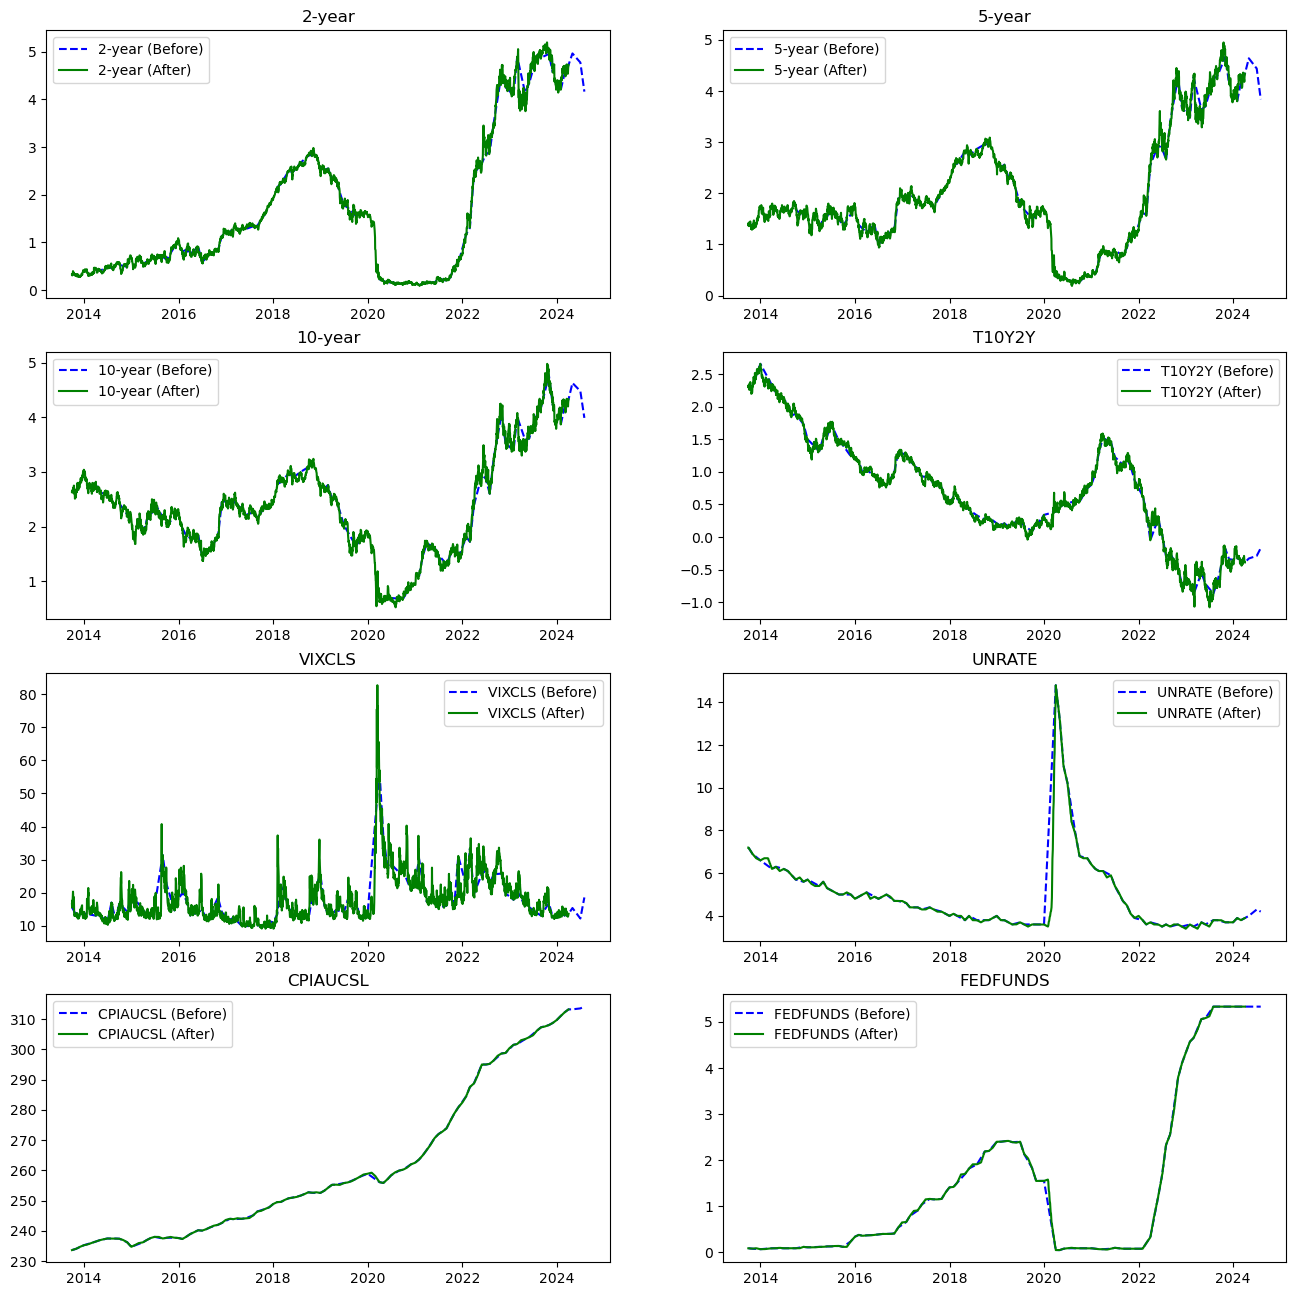

In [20]:
# 그래프 그리기: 보간 전후 비교
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))

columns = econ_df.columns
for i, col in enumerate(columns):
    row, col_num = divmod(i, 2)
    axs[row, col_num].plot(og_df.index, og_df[col], label=f'{col} (Before)', color='blue', linestyle='--')
    axs[row, col_num].plot(econ_df.index, econ_df[col], label=f'{col} (After)', color='green')
    axs[row, col_num].set_title(col)
    axs[row, col_num].legend()

plt.tight_layout()
plt.show()

# 1.3. Fundamental _ 산업

In [23]:
## 3.1. Load major stock indices
df = yf.download("^DJI", start=start_date, end=end_date)  # Dow Jones
df1 = yf.download("^IXIC", start=start_date, end=end_date)  # NASDAQ
df2 = yf.download("^GSPC", start=start_date, end=end_date)  # S&P 500
df3 = yf.download("^RUT", start=start_date, end=end_date)  # Russell 2000

# Rename Columns
df.rename(columns={'Adj Close': 'DJI Adj Close', 'Volume': 'DJI Volume'}, inplace=True) 
df1.rename(columns={'Adj Close': 'NDAQ Adj Close', 'Volume': 'NDAQ Volume'}, inplace=True)
df2.rename(columns={'Adj Close': 'SPX Adj Close', 'Volume': 'SPX Volume'}, inplace=True)
df3.rename(columns={'Adj Close': 'RUT Adj Close', 'Volume': 'RUT Volume'}, inplace=True)

# Select columns
df = df[['DJI Adj Close', 'DJI Volume']] 
df1 = df1[['NDAQ Adj Close', 'NDAQ Volume']]
df2 = df2[['SPX Adj Close', 'SPX Volume']]
df3 = df3[['RUT Adj Close', 'RUT Volume']]

Index_data = pd.concat([df, df1, df2, df3], axis=1, join='outer')
Index_data = Index_data.join(stock_df['Adj Close'], how='left')

## 3.2. "Industry Sector data based on ETF
sectors = {
    "VDE": "Energy",                 # Vanguard Energy ETF
    "MXI": "Materials",              # iShares Global Materials ETF
    "VIS": "Industrials",            # Vanguard Industrials ETF
    "VCR": "Consumer Cyclical",      # Vanguard Consumer Discretionary ETF
    "XLP": "Consumer Staples",       # Consumer Staples Select Sector SPDR Fund
    "VHT": "Health Care",            # Vanguard Healthcare ETF
    "XLF": "Financials",             # Financial Select Sector SPDR Fund
    "VGT": "Information Technology", # Vanguard Information Technology ETF
    "VOX": "Communication Services", # Vanguard Communication Services ETF
    "XLU": "Utilities",              # Utilities Select Sector SPDR Fund
    "VNQ": "Real Estate"             # Vanguard Real Estate Index Fund
}
sector_data = {}

# Load Adj Close and Volumes for the ETF industry sector
for sector, sector_name in sectors.items():
    data = yf.download(sector, start=start_date, end=end_date)
    data.rename(columns={
        'Adj Close': f'{sector_name} Adj Close',
        'Volume': f'{sector_name} Volume'
    }, inplace=True) 
    sector_data[sector] = data[[f'{sector_name} Adj Close', f'{sector_name} Volume']]
    
ETF = pd.concat(sector_data.values(), axis=1)

# Matching the adjusted closing prices and trading volumes for the ETF industry sector associated with the entered ticker's sector
sector = yf.Ticker(ticker).info.get('sector', None)
sector_columns = [col for col in ETF.columns if sector in col] 
sector_df = ETF[sector_columns]

# Merge into industry data
Industry_df = Index_data.merge(sector_df, on="Date", how="inner")


Industry_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,DJI Adj Close,DJI Volume,NDAQ Adj Close,NDAQ Volume,SPX Adj Close,SPX Volume,RUT Adj Close,RUT Volume,Adj Close,Information Technology Adj Close,Information Technology Volume
Date,,,,,,,,,,,
2013-09-30,15129.669922,122330000,3771.479980,1895760000,1681.550049,3308630000,1073.790039,3308630000,14.784491,72.227180,380600
2013-10-01,15191.700195,82460000,3817.979980,1843320000,1695.000000,3238690000,1087.430054,3238690000,15.132123,72.996925,160200
2013-10-02,15133.139648,86090000,3815.020020,1792980000,1693.869995,3148600000,1082.550049,3148600000,15.181740,73.023750,350700
2013-10-03,14996.480469,91300000,3774.340088,1884340000,1678.660034,3279650000,1070.900024,3279650000,14.991021,72.254036,216800
2013-10-04,15072.580078,75100000,3807.750000,1549600000,1690.500000,2880270000,1078.250000,2880270000,14.979239,72.746307,456100
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-11,40861.710938,356040000,17395.529297,6086930000,5554.129883,3839450000,2103.850098,3839450000,222.660004,561.580017,482900
2024-09-12,41096.769531,289300000,17569.679688,4983120000,5595.759766,3655070000,2129.429932,3655070000,222.770004,565.900024,417800
2024-09-13,41393.781250,276800000,17683.980469,4802880000,5626.020020,3500790000,2182.489990,3500790000,222.500000,569.239990,313100


In [24]:
tech_df = stock_df
fund_df = econ_df.merge(Industry_df, on="Date", how="inner")

file_path = '/Users/jongheelee/Desktop/JH/주가예측/data/tech_df.csv'  
tech_df.to_csv(file_path, index=True)

file_path = '/Users/jongheelee/Desktop/JH/주가예측/data/fund_df.csv' 
fund_df.to_csv(file_path, index=True)
